In [4]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import numpy as np
import os

In [5]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [6]:
from pathlib import Path
dir_path_val = Path('C:/Users/zhuko/imagenette2-160/val/')
dir_path_train=Path('C:/Users/zhuko/imagenette2-160/train/')

In [7]:
# Load the Data

# Set train and valid directory paths

dataset = 'imagenette2'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
#test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = 10

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=dir_path_train, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=dir_path_val, transform=image_transforms['valid']),
}

#Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

{0: 'n01440764', 1: 'n02102040', 2: 'n02979186', 3: 'n03000684', 4: 'n03028079', 5: 'n03394916', 6: 'n03417042', 7: 'n03425413', 8: 'n03445777', 9: 'n03888257'}


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size)
print(valid_data_size)

9469
3925


# ResNet50

In [9]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
resnet50 = resnet50.to(device)

In [10]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [198]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

In [104]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters(),lr=1e-2)

In [21]:
def train_and_validate(model, loss_criterion, optimizer, epochs=3):
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        correct_5=0.0
        correct=0
        c=0
        total=0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
#             print("Batch number: {:03d}, Valid: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        #Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
                
                # Compute top-5 accuracy
                total+=labels.size(0)
                c+=(predictions==labels).sum().item()
                pred=outputs.topk(5,largest=True,sorted=True)[0]
                lab=labels.view(labels.size(0),-1).expand_as(pred)
                correct=pred.eq(lab).float()
                correct_5+=correct[:,:5].sum()
                
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        #Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        print('Top 5 error:%2.2f' % (1-correct_5/total))        
#         # Save if the model has best accuracy till now
#         torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history, best_epoch

In [22]:
# Train the model for num epochs:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Epoch : 000, Training: Loss - 0.2615, Accuracy - 93.0404%, 
		Validation : Loss - 0.0977, Accuracy - 97.2994%, Time: 1395.1665s
Top 5 error:0.93
Epoch: 2/3
Epoch : 001, Training: Loss - 0.2430, Accuracy - 93.6952%, 
		Validation : Loss - 0.1200, Accuracy - 97.0191%, Time: 1391.5943s
Top 5 error:0.92
Epoch: 3/3
Epoch : 002, Training: Loss - 0.2277, Accuracy - 94.3711%, 
		Validation : Loss - 0.0685, Accuracy - 98.1656%, Time: 1337.8660s
Top 5 error:0.91


# Попробуем MobileNet 3й версии, Small.

In [10]:
mobilenet_2=models.mobilenetv3.mobilenet_v3_small(weights='DEFAULT')
mobilenet_2=mobilenet_2.to(device)

In [255]:
mobilenet_2

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [71]:
# Freeze model parameters
for param in mobilenet_2.parameters():
    param.requires_grad = False

In [74]:
# Change the final layer of mobilenet Model for Transfer Learning
fc_inputs = mobilenet_2.classifier[0].in_features

mobilenet_2.classifier = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.Hardswish(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
mobilenet_2 = mobilenet_2.to(device)

In [190]:
# Define Optimizer and Loss Function
optimizer = optim.Adam(mobilenet_2.parameters(),lr=1e-2)

In [77]:
# Train the model for num epochs:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(mobilenet_2, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Epoch : 000, Training: Loss - 0.5715, Accuracy - 82.7437%, 
		Validation : Loss - 0.3379, Accuracy - 89.7834%, Time: 155.1565s
Top 5 error:0.96
Epoch: 2/3
Epoch : 001, Training: Loss - 0.4893, Accuracy - 85.3839%, 
		Validation : Loss - 0.2471, Accuracy - 92.6115%, Time: 147.1166s
Top 5 error:0.95
Epoch: 3/3
Epoch : 002, Training: Loss - 0.4539, Accuracy - 87.1370%, 
		Validation : Loss - 0.2433, Accuracy - 93.0701%, Time: 146.9355s
Top 5 error:0.96


# EfficientNet

In [11]:
efficientnet=models.efficientnet.efficientnet_v2_s(weights='DEFAULT')
efficientnet=efficientnet.to(device)

In [18]:
efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
# Freeze model parameters
for param in efficientnet.parameters():
    param.requires_grad = False

In [21]:
# Change the final layer of efficientnet Model for Transfer Learning
fc_inputs = efficientnet.classifier[1].in_features

efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(fc_inputs, out_features=10), # Since 10 possible outputs            
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
efficientnet = efficientnet.to(device)

In [22]:
# Define Optimizer and Loss Function
optimizer = optim.Adam(efficientnet.parameters(),lr=1e-2)

In [24]:
# Train the model for num epochs:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(efficientnet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Epoch : 000, Training: Loss - 0.2537, Accuracy - 93.6319%, 
		Validation : Loss - 0.1225, Accuracy - 96.9682%, Time: 1468.0562s
Top 5 error:0.97
Epoch: 2/3
Epoch : 001, Training: Loss - 0.2480, Accuracy - 94.4450%, 
		Validation : Loss - 0.1295, Accuracy - 96.9936%, Time: 1468.0462s
Top 5 error:0.94
Epoch: 3/3
Epoch : 002, Training: Loss - 0.2431, Accuracy - 95.1209%, 
		Validation : Loss - 0.1353, Accuracy - 97.0701%, Time: 1460.1208s
Top 5 error:0.93


# Попробуем DenceNet версии 121.

In [12]:
densenet=models.densenet.densenet121(weights='DEFAULT')
densenet=densenet.to(device)

In [54]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [55]:
# Freeze model parameters
for param in densenet.parameters():
    param.requires_grad = False

In [56]:
# # Change the final layer of densenet Model for Transfer Learning
fc_inputs = densenet.classifier.in_features

densenet.classifier =  nn.Sequential(
    nn.Linear(fc_inputs, out_features=10),
    nn.LogSoftmax(dim=1)                   # For using NLLLoss()
)

#Convert model to be used on GPU
densenet = densenet.to(device)

In [57]:
# Define Optimizer and Loss Function
optimizer = optim.Adam(densenet.parameters(),lr=1e-2)

In [59]:
# Train the model for num epochs:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(densenet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Epoch : 000, Training: Loss - 0.2763, Accuracy - 91.4986%, 
		Validation : Loss - 0.1485, Accuracy - 95.8981%, Time: 1266.1481s
Top 5 error:0.93
Epoch: 2/3
Epoch : 001, Training: Loss - 0.2265, Accuracy - 94.5190%, 
		Validation : Loss - 0.1305, Accuracy - 96.6879%, Time: 1254.1220s
Top 5 error:0.92
Epoch: 3/3
Epoch : 002, Training: Loss - 0.2206, Accuracy - 94.7407%, 
		Validation : Loss - 0.1234, Accuracy - 97.1720%, Time: 1265.3808s
Top 5 error:0.93


# inception_v3

In [13]:
inception = models.inception_v3(pretrained=True)
inception=inception.to(device)

C:\Users\zhuko\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zhuko\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [230]:
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [216]:
# Applying Transforms to the Data специально для inception_v3
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                          # ToTensor : [0, 255] -> [0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]),
    'valid': transforms.Compose([
       transforms.Resize((299, 299)),
       transforms.ToTensor(),                          # ToTensor : [0, 255] -> [0, 1]
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]),
}

In [217]:
from pathlib import Path
dir_path_val = Path('C:/Users/zhuko/imagenette2-160/val/')
dir_path_train=Path('C:/Users/zhuko/imagenette2-160/train/')

In [218]:
# Load the Data

# Set train and valid directory paths

dataset = 'imagenette2'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
#test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = 10

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=dir_path_train, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=dir_path_val, transform=image_transforms['valid']),
}

#Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

{0: 'n01440764', 1: 'n02102040', 2: 'n02979186', 3: 'n03000684', 4: 'n03028079', 5: 'n03394916', 6: 'n03417042', 7: 'n03425413', 8: 'n03445777', 9: 'n03888257'}


In [231]:
# Freeze model parameters
inception.aux_logits = False

for parameter in inception.parameters():
    parameter.requires_grad = False

In [232]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size)
print(valid_data_size)

9469
3925


In [235]:
# Change the final layer of efficientnet Model for Transfer Learning
inception.fc = nn.Sequential(
    nn.Linear(inception.fc.in_features, out_features=10),
    nn.LogSoftmax(dim=1)
)

In [237]:
# Define Optimizer and Loss Function
optimizer = optim.Adam(inception.parameters(),lr=1e-2)

In [239]:
# Train the model for num epochs:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(inception, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Epoch : 000, Training: Loss - 0.6694, Accuracy - 84.3067%, 
		Validation : Loss - 0.1258, Accuracy - 97.0955%, Time: 1390.0534s
Top 5 error:1.00
Epoch: 2/3
Epoch : 001, Training: Loss - 0.8093, Accuracy - 86.8941%, 
		Validation : Loss - 0.1280, Accuracy - 97.6561%, Time: 1346.0287s
Top 5 error:0.93
Epoch: 3/3
Epoch : 002, Training: Loss - 0.8534, Accuracy - 87.9079%, 
		Validation : Loss - 0.2419, Accuracy - 96.0000%, Time: 1344.3013s
Top 5 error:0.97


In [ ]:
#Для построения графика нужно знать количество параметров нейросети

In [14]:
resnet50_params=sum(p.numel() for p in resnet50.parameters())
resnet50_params

25557032

In [15]:
mobilenet_2_params=sum(p.numel() for p in mobilenet_2.parameters())
mobilenet_2_params

2542856

In [16]:
efficientnet_params=sum(p.numel() for p in efficientnet.parameters())
efficientnet_params

21458488

In [17]:
densenet_params=sum(p.numel() for p in densenet.parameters())
densenet_params

7978856

In [18]:
inception_params = sum(p.numel() for p in inception.parameters())
inception_params

27161264

In [19]:
import pandas as pd
df = pd.DataFrame({'models': ['resnet50', 'mobilenet_v3_small', 'efficientnet_v2_s','densenet121', 'inception_v3'], 
                   'top_5_accuracy': [92, 95.7, 94.7, 92.7, 97.7], 
                   'models_params': [25557032, 2542856, 20210788, 6964106, 25132754]})

In [20]:
df

,models,top_5_accuracy,models_params
0,resnet50,92.0,25557032
1,mobilenet_v3_small,95.7,2542856
2,efficientnet_v2_s,94.7,20210788
3,densenet121,92.7,6964106
4,inception_v3,97.7,25132754


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

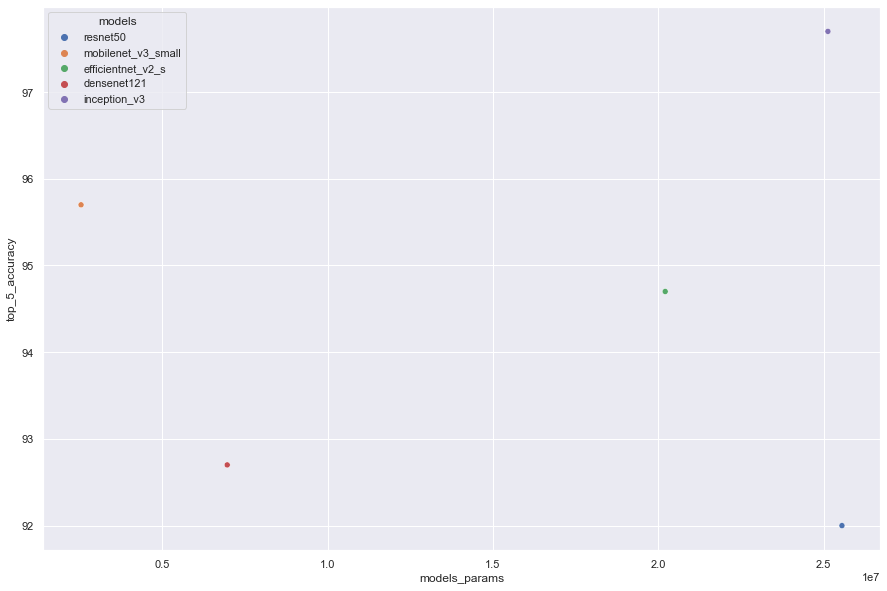

In [25]:
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(
    data=df, x="models_params", y="top_5_accuracy", hue="models",
)